# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

## Откройте и изучите файл

In [2]:
try:
    data = pd.read_csv('datasets/users_behavior.csv', sep=',')
except FileNotFoundError: 
    data = pd.read_csv('/datasets/users_behavior.csv', sep=',')

In [3]:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
data = data.astype({
                    'calls' : 'int64', 
                    'messages' : 'int64',
                   })


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


<AxesSubplot:>

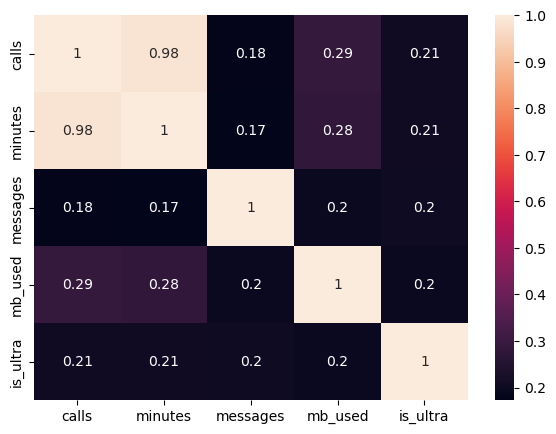

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data.corr(), fmt='.2g', annot=True)

* Сильная корреляция между минутами и количеством звонков. Исключаем количество звонков, как менее информативный признак.

In [7]:
data.drop(['calls'], inplace=True, axis=1)

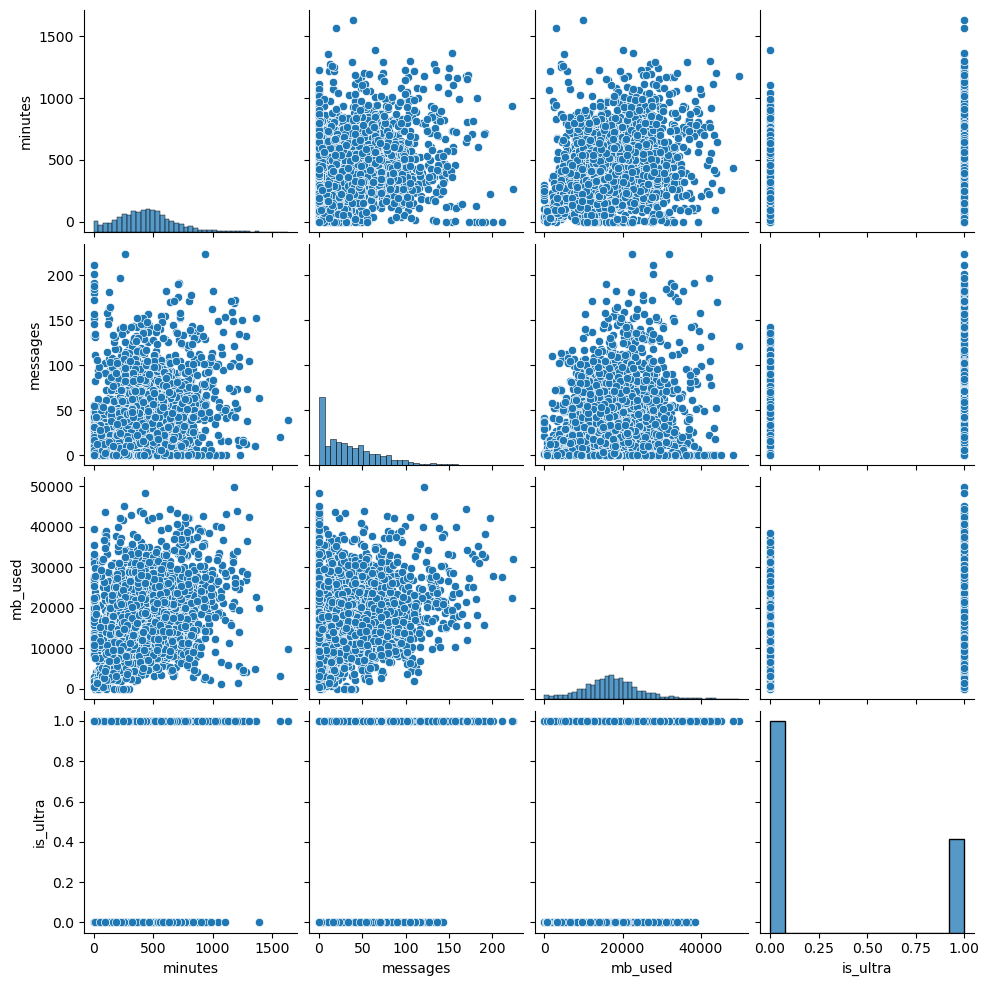

In [8]:
sns.pairplot(data)

In [9]:
data = data.query('minutes <1300 & messages < 200 & mb_used < 45000')

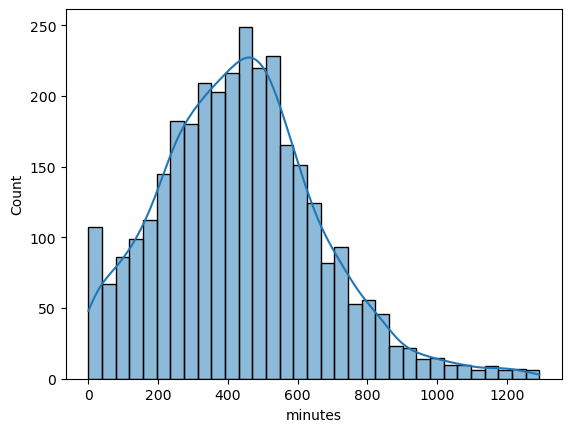

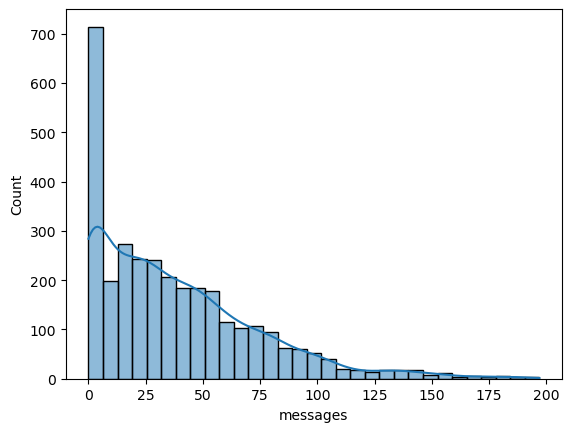

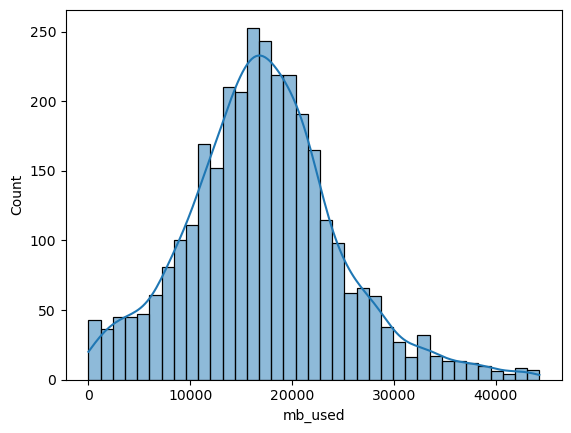

In [10]:
for col in data.columns:
    if col != 'is_ultra':
        sns.histplot(data[col], kde=True)
        plt.show()

* Отсекли выбросы
* Нули в сообщениях и минутах не являются выбросами или ошибками, поскольку очень большая группа людей не пользуется этими услугами.

In [11]:
data.is_ultra.value_counts()

0    2228
1     973
Name: is_ultra, dtype: int64

* Есть перекос по классам, но объектов с 1 вполне достаточно.

## Разбейте данные на выборки

In [12]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=12345)

In [13]:
scaler = StandardScaler()
scaler.fit(features_train)
features_scaled_train = scaler.transform(features_train)
features_scaled_test = scaler.transform(features_test)
features_scaled_train = pd.DataFrame(features_scaled_train, columns=features.columns)
features_scaled_test = pd.DataFrame(features_scaled_test, columns=features.columns)

## Исследуйте модели

* Подбораем гиперпараметры и обучением модели

In [14]:
dtc = DecisionTreeClassifier(random_state=12345)
gridsearch_dtc = GridSearchCV(dtc, 
                              param_grid={'max_depth': range(3, 10, 1)}, 
                              scoring='accuracy', 
                              cv=cv)
gridsearch_dtc.fit(features_train, target_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(3, 10)}, scoring='accuracy')

In [15]:
rfc = RandomForestClassifier(random_state=12345)
gridsearch_rfc = GridSearchCV(rfc, 
                              param_grid={'max_depth': range(3, 10, 2), 
                                          'n_estimators': range(10, 200, 10)}, 
                              scoring='accuracy', 
                              cv=cv)
gridsearch_rfc.fit(features_train, target_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(3, 10, 2),
                         'n_estimators': range(10, 200, 10)},
             scoring='accuracy')

In [16]:
lr = LogisticRegression(random_state=12345, penalty='l2')
gridsearch_lr = GridSearchCV(lr, 
                              param_grid={'C': np.logspace(-1, 2, 10)}, 
                              scoring='accuracy', 
                              cv=cv)
gridsearch_lr.fit(features_scaled_train, target_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(random_state=12345),
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ])},
             scoring='accuracy')

In [17]:
grid_params = {'n_estimators': range(10, 200, 10),
                'max_depth': range(3,10,2),
              }

params = {#'n_estimators': 50,
          #  'learning_rate': 0.01,
          # 'max_depth': 10,
          # 'min_child_weight': 1,
          # 'subsample': 0.8,
          # 'colsample_bytree': 0.8,
          'n_jobs': -1}
gridsearch_xgb = GridSearchCV(xgb.XGBClassifier(**params), param_grid=grid_params, scoring='accuracy', cv=cv)
gridsearch_xgb.fit(features_train, target_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=No...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
              

In [18]:
train_score = pd.DataFrame(
    [
        [gridsearch_dtc.best_score_],
        [gridsearch_rfc.best_score_],
        [gridsearch_lr.best_score_],
        [gridsearch_xgb.best_score_]
    ],
    
    columns = [
        'Accuracy'
    ],
    index = [
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'LogisticRegression',
        'XGBClassifier'
    ]
)

train_score.sort_values(by='Accuracy', ascending=False).style.bar()

,Accuracy
RandomForestClassifier,0.808594
XGBClassifier,0.807422
DecisionTreeClassifier,0.792578
LogisticRegression,0.740234


### Вывод:  
* Случайный лес побеждает, но разница по метрике с бустингом незначительная. Посмотрим что будет на тестовой выборке.  
* Хуже всего справляется логистическая регрессия. Ее и дерево решений дальше не используем.

## Проверьте модель на тестовой выборке

In [19]:
rfc_best = gridsearch_rfc.best_estimator_
xgb_best = gridsearch_xgb.best_estimator_

In [20]:
print (f'Лучший accuracy для случайного леса: {accuracy_score(rfc_best.predict(features_test), target_test):.5f}')
print (f'Лучший accuracy для бустинга леса: {accuracy_score(xgb_best.predict(features_test), target_test):.5f}')

Лучший accuracy для случайного леса: 0.82059
Лучший accuracy для бустинга леса: 0.82059


### Вывод:  
* Офигеть!

## (бонус) Проверьте модели на адекватность

<AxesSubplot:>

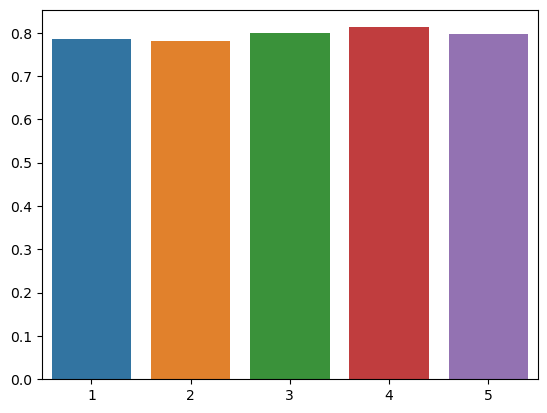

In [21]:
cv_results = []
splits = gridsearch_rfc.cv.get_n_splits()
for i in range(splits):
    cv_results.append(gridsearch_rfc.cv_results_.get(f'split{i}_test_score').mean())
sns.barplot(y =cv_results, x=np.array(range(1, splits+1)))

In [26]:
dc = DummyClassifier(strategy="most_frequent", random_state=12345)
dc.fit(features_train, target_train)
print (f'Лучший accuracy для случайного леса: {accuracy_score(rfc_best.predict(features_test), target_test):.5f}')
print (f'accuracy для DummyClassifier: {accuracy_score(dc.predict(features_test), target_test):.5f}')

Лучший accuracy для случайного леса: 0.82059
accuracy для DummyClassifier: 0.70515


In [24]:
pd.DataFrame(rfc_best.predict(features_test)).value_counts()

0    527
1    114
dtype: int64

### Выводы:
* Модель ведет себя усточиво и не переобучена.
* Лучшего качества удалось добиться при использовании случайного леса.
* Распределение классов в предсказании примерно совпадает с распределением классов в целевой переменной.
* Модель предсказывает лучше простого dummy классификатора, отсюда следует, что модель адекватна.

In [ ]:
# import tensorflow as tf
# import keras
# import os
# from keras.models import Sequential
# from keras.layers import Dense,Activation
# from keras.optimizers import SGD
# from keras import losses

In [ ]:
# num_inputs=4
# num_outputs=2
# num_layers=10
# num_neurons=[]
# for i in range(num_layers):
#     num_neurons.append(128)
# learning_rate=0.0001
# n_epochs=200
# batch_size=100

In [ ]:
# model=Sequential()

# for i in range(len(num_neurons)):
#     model.add(Dense(units=num_neurons[i],activation='relu',
#                input_shape=(num_inputs,)))

# model.add(Dense(units=num_outputs,activation='softmax'))

# model.summary()

In [ ]:
# model.compile(loss=losses.sparse_categorical_crossentropy, optimizer = tf.keras.optimizers.Adam() , metrics=['accuracy'])
# # Тренировочная модель
# model.fit(features, target, batch_size=batch_size, epochs=n_epochs)